Date: 2 August 2021

Author: Shubham Maheshwari

Contact: shubham.93@gmail.com

*Note: The code may be found on my GitHub account at https://github.com/shubham-93/Sunspots-data-analysis and on my Kaggle account at https://www.kaggle.com/shubhammaheshwari1/sunspots-analysis.*

# Time series analysis of sunspots data

# Introduction

Sunspots are dark spots observed on the surface of the sun whose number and surface area change with time. This lends the phenomenon naturally to a time series analysis problem. Sunspots are measured using both ground-based and orbitting solar telescopes. Observing and studying sunspots presents an excellent window into understanding solar (and hence stellar) physics, particularly the solar cycle. The solar cycle is a roughly 11-year cycle of solar activity characterized by changes in the magnetic field activity generated by the sun. Sunspots are regions of high concentrations of magnetic field on the sun's surface, and are cooler in temperature compared to their surroundings. Rising solar activity is associated with the outburst of energetic particles outward from the sun which affects the Earth's upper atmosphere, making sensitive instruments in space vulnerable to damage. Moreover, solar activity also possibly affects terrestrial climate. Studying the time variation of sunspot numbers provides a cheap and easy way to continuously monitor, understand and predict the various effects of the solar cycle.

We will perform the following tasks:

1. Clean and prepare the data for exploratory data analysis

2. Use plots (line and data points) to show seasonality, local maxima and minima in sunspot numbers over the years.

3. Using boxplots, show that sunspot numbers do not vary much around minima but fluctuate more as solar activity increases. Show that the interquartile range itself displays seasonality and coincides with the solar cycle.

4. Use lag plots and autocorrelation plots to show that the data is not random and possesses strong seasonality. We recover the well-known solar cycle of around 11 years. We also show the presence of a weaker season of around 120 years.

5. Remove jitters in the original data and present a much cleaner moving average plot. This recovers the well-known Dalton Minimum period from 1790 to 1820 of low solar activity.

6. Visually show the asymmetry between rises and falls in solar activity - the time taken to go from a minimum to a maximum tends to be shorter than the one taken to go from the same maximum to the next minimum.

7. Use a heatmap to concisely visualize solar activity over the years, and recover the solar cycle and the longer season of 120 years.

8. Collect all the maxima and find the consecutive time differences between them to recover the solar cycle as the mean of a normal distribution. Show, using a quantile-quantile plot, that the distribution roughly follows a normal curve.

9. Visually and numerically show the presence of multiple consecutive minimum data points, which make periods of lowest solar activity during the Dalton Minimum period flat-looking.

# Introduction to the data

The input data is a time series. There is only one variable, called 'Monthly Mean Total Sunspot Number', associated with the end of every month for more than 250 years, from January 1749 to January 2021. The mean sunspot number varies from a minimum of 0 to a maximum of 398.2, with a mean of 81.78.

Below, we quickly prepare the dataframe to be used for data visualization after.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema
import statsmodels.api as sm
%matplotlib inline

Reading and slight cleaning of data:

In [2]:
df = pd.read_csv("../input/sunspots/Sunspots.csv", index_col = 1, parse_dates = True)
df.drop(columns = 'Unnamed: 0',inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3265 entries, 1749-01-31 to 2021-01-31
Data columns (total 1 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Monthly Mean Total Sunspot Number  3265 non-null   float64
dtypes: float64(1)
memory usage: 51.0 KB


The first few entries look like this:

In [3]:
df.head()

,Monthly Mean Total Sunspot Number
Date,
1749-01-31,96.7
1749-02-28,104.3
1749-03-31,116.7
1749-04-30,92.8
1749-05-31,141.7


Summary statistics of the Monthly Mean Total Sunspot Number:

In [4]:
df.describe()

,Monthly Mean Total Sunspot Number
count,3265.000000
mean,81.778775
std,67.889277
min,0.000000
25%,23.900000
50%,67.200000
75%,122.500000
max,398.200000


Time indices are already sorted from past to present in an ascending order, and none of the values in the 'Monthly Mean Total Sunspot Number' column are null:


In [5]:
print(df.index.is_monotonic_increasing)
df.isnull().sum()

True


Monthly Mean Total Sunspot Number    0
dtype: int64

# Exploratory Data Analysis

We will now use a variety of visualization and statistical techniques to better understand the data.

We can plot a histogram to visualize the frequency distribution of the 'Monthly Mean Total Sunspot Number':

array([[<AxesSubplot:title={'center':'Monthly Mean Total Sunspot Number'}>]],
      dtype=object)

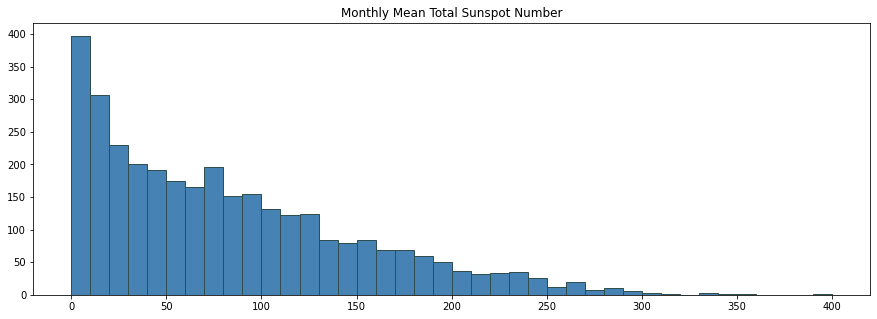

In [6]:
bins=np.arange(0,401,10)
df.hist(bins=bins, figsize = (15,5), color = 'steelblue', edgecolor = 'darkslategrey', grid = False)

which shows steadily decreasing frequencies for larger values of 'Monthly Mean Total Sunspot Number'. This is not a normal distribution and lower values of 'Monthly Mean Total Sunspot Number' are more frequent than higher values.

Line plot for the 'Monthly Mean Total Sunspot Number' for all monthly observations from the beginning of the date index to the end:

<AxesSubplot:xlabel='Month (in a year)', ylabel='Monthly Mean Total Sunspot Number'>

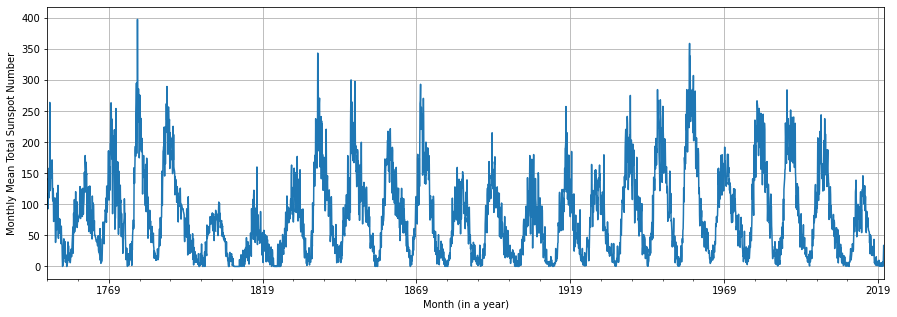

In [7]:
df.plot(figsize = (15,5), grid = True, xlabel = 'Month (in a year)', ylabel = 'Monthly Mean Total Sunspot Number', legend = False)

In [8]:
# We can resample the data based on a different time period like year (and not month). For instance, we could do
# 1) df.resample('Y').sum().head()
# or 2) do year_groups.sum() where year_groups = df.groupby(pd.Grouper(freq='Y'))

First, note that because the number of data points (3265) is too high, the plot's x-axis zooms out and just shows the year (and not the month). However, we will choose to keep the plot like this with the implicit fact that the x-axis coordinates are actually months. To this end, the x-axis is labeled "Month (in a year)".

The line plot shows that the data is not random - there is seasonality, with multiple peaks and troughs. Moreoever, the peaks (troughs) seem to occur after a specific time interval. We will determine this interval soon. This is the well-known **solar cycle**.

A line plot with many dense data points can obfuscate the picture, however, so we also make a plot where data is represented by just dots:

<AxesSubplot:xlabel='Month (in a year)', ylabel='Monthly Mean Total Sunspot Number'>

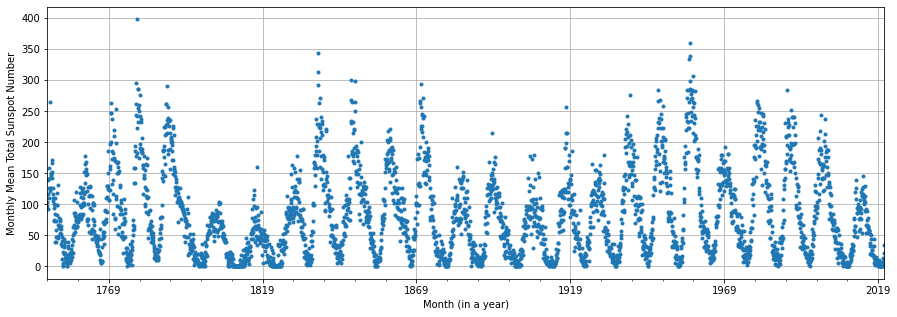

In [9]:
df.plot(figsize = (15,5),grid = True, xlabel = 'Month (in a year)', ylabel = 'Monthly Mean Total Sunspot Number', legend = False, style = '.')

The data points plot above seems to reveal another property of the data (although not too clearly). It looks like the points are dense around local minima and sparse around local maxima. This suggests that the change in sunspot numbers is large and quick around local maxima (during the rise and subsequent fall) in comparison to the changes near local minima. We will confirm this graphically and quantitatively with a zoomed-in version of the above plot for a shorter time period, and a series of **boxplots**.

But before moving on to that, we will determine the solar cycle time period by studying the autocorrelation within the data.

**Lag plots** are useful for checking whether the data is random or not. If there is an observable pattern in the lag plot, we can leverage that information to make predictions. Below we have the lag plot of the sunspot numbers data:

Text(0.5, 1.0, 'Lag plot of sunspot numbers')

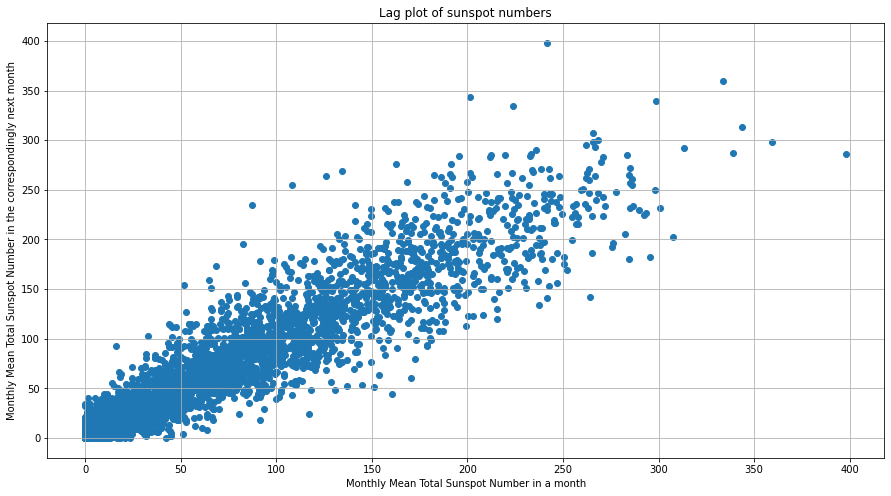

In [10]:
plt.figure(figsize = (15,8))
ax = pd.plotting.lag_plot(df)
ax.grid()
ax.set_xlabel('Monthly Mean Total Sunspot Number in a month')
ax.set_ylabel('Monthly Mean Total Sunspot Number in the correspondingly next month')
ax.set_title('Lag plot of sunspot numbers')

We see a strong and positive correlation. This implies that the data is not random. Moreover, it means that as sunspot numbers rise, they tend to keep rising (and vice versa).

An **autocorrelation plot** of the sunspot data will offer the opportunity to see how correlation varies across different lags. This will help us in detecting seasonality and determining the **solar cycle**:

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

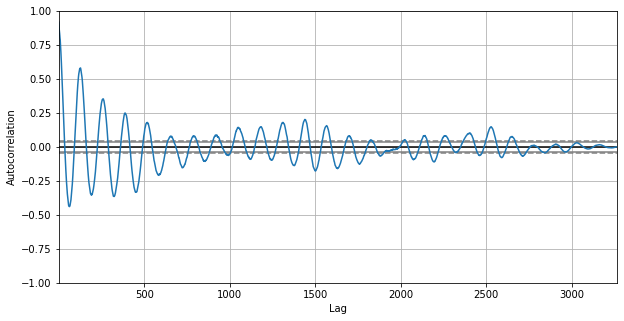

In [11]:
plt.figure(figsize = (10,5))
pd.plotting.autocorrelation_plot(df)

From the above autocorrelation plot, we see that the first maximum occurs at some finite value of lag. We can find this lag value as follows:

In [12]:
lag_vals = np.arange(12*15)
autocorr_ser = np.array([df['Monthly Mean Total Sunspot Number'].autocorr(lag=n) for n in lag_vals])
argrelextrema(autocorr_ser, np.greater, order = 2)[0]
# we choose order = 2 because order = 1 gives two local maxima at lags = 125 and 128 months.

array([128])

So we see that at lag = 128 months = **10.67 years**, the sunspot data shows seasonality. This recovers the well-known **solar cycle**, which has a period of about 11 years. But note also the curious local maximum in autocorrelation at a lag of around 1500 months. This signals the presence of a longer season than the usual solar cycle of 11 years. Though the autocorrelation at this second maximum is not high, it would be worth considering since it will reveal another season longer than the 11-year solar cycle. We extend the range of lag values, and also the order of data points for comparison when finding the local maximum. It turns out that an order of 130 singles out the sought-after lag value:

In [13]:
lag_vals = np.arange(1700)
autocorr_ser = np.array([df['Monthly Mean Total Sunspot Number'].autocorr(lag=n) for n in lag_vals])
argrelextrema(autocorr_ser, np.greater, order = 130)[0]

array([1440])

This signals the presence of a **longer cycle** of 1440/12 = **120 years**. Although this cycle is visually less apparent from the first line plot of the full data, it is clearer from a **heatmap** as we will see soon. However, we must mention that there is not enough data to be confident about the presence of this 120-year pattern because we have information of about 270 years which is only about twice this time period.

The first line plot with 3265 data points is difficult to interpret because of many fluctuations. Where are the highest highs, the lowest lows, and valleys in the sunspot number data? To answer this, we smooth out the jitters in the full data by calculating and plotting its **moving average** for a fixed time window of 11 years, corresponding roughly to the time period of one solar cycle. We do not choose a larger time window because it washes out local minima and maxima which cannot be ignored. The moving average reveals a crystal clear overview of long-term sunspot numbers:

<AxesSubplot:xlabel='Month (in a year)', ylabel='11-year moving average of the Monthly Mean Total Sunspot Number'>

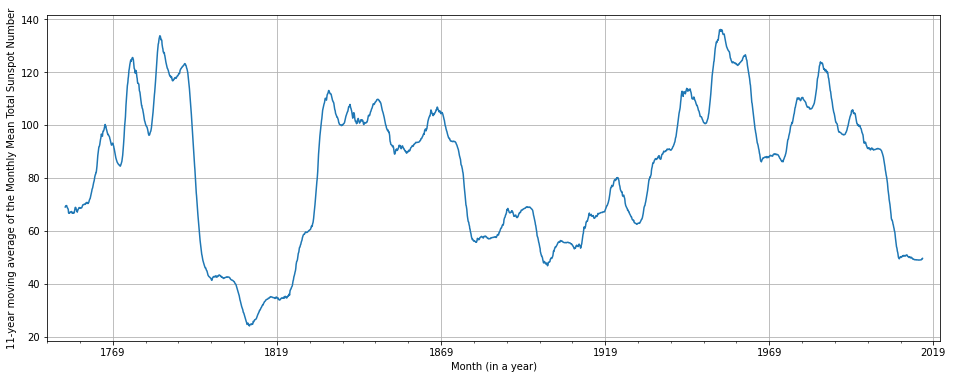

In [14]:
rolling_avg = df['Monthly Mean Total Sunspot Number'].rolling(window = 12*11, closed = 'both', center =  True).mean()
rolling_avg.plot(figsize = (16,6),grid = True, xlabel = 'Month (in a year)', ylabel = '11-year moving average of the Monthly Mean Total Sunspot Number')

The moving average plot now clearly exposes the lows, highs and valleys in sunspot numbers over the years. We see a deep minimum and a steep valley from around 1790 to 1820 - this is the **Dalton Minimum** named after the English meteorologist John Dalton. Then, after a surge in sunspot numbers until around 1860, we again see a dip and a wide valley. There is a peak at around 1960, then a rapid drop around 1969, then a rise and then a drop again until a few years ago.

The **Dalton Minimum** coincides with a period of lower-than-average global temperatures (https://en.wikipedia.org/wiki/Year_Without_a_Summer). Although the temperature anomaly was probably a result of a volcanic winter due to the eruption of Mount Tambora in 1815 in Indonesia, interestingly, there have been proposals that connect solar activity with volcanic activity on Earth (https://peratonweather.com/blog/2020/1/16/715-am-the-solar-minimum-and-an-increase-in-volcanic-activity). More research needs to be done to verify this, but if there is indeed a connection, then it might help us connect sunspot numbers with volcanic activity on Earth and ensuing climate changes!

As we stated earlier, it is easy to get overwhelmed with data spanning more than 250 years, so it is useful to zoom in to a specific time period for visual clarity. Here we show a line plot for the time period between 1850 and 1880:

<AxesSubplot:xlabel='Month (in a year)', ylabel='Monthly Mean Total Sunspot Number'>

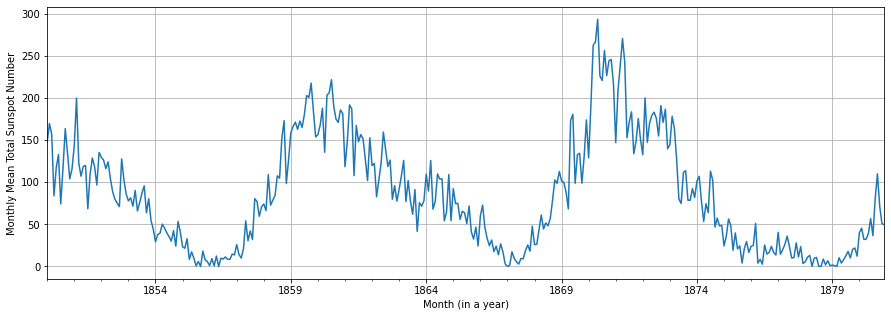

In [15]:
df.loc['1850':'1880'].plot(figsize = (15,5),grid = True, xlabel = 'Month (in a year)', ylabel = 'Monthly Mean Total Sunspot Number', legend = False)

Zooming in to smaller time periods helps in clearly seeing the variation in sunspot numbers over the years.

If we just want the data points for the same time period, we have:

<AxesSubplot:xlabel='Month (in a year)', ylabel='Monthly Mean Total Sunspot Number'>

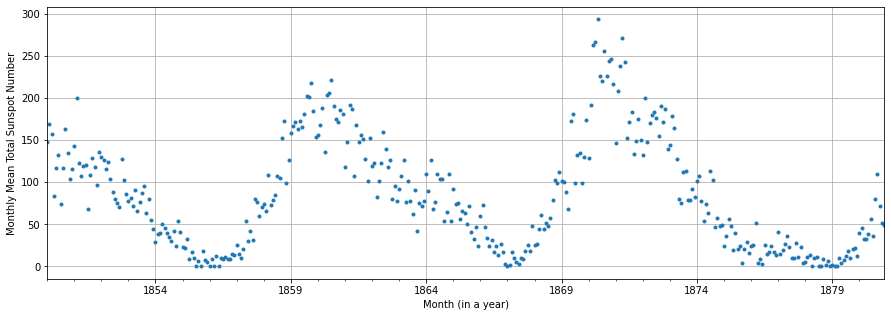

In [16]:
df.loc['1850':'1880'].plot(figsize = (15,5),grid = True, xlabel = 'Month (in a year)', ylabel = 'Monthly Mean Total Sunspot Number', legend = False, style = '.')

Now, it is clearer that the data points are dense around minima but sparse around maxima. This means that when the sun is experiencing low solar activity, it tends to remain in that 'dormant' state. However, as soon as solar activity picks up, the change (rise and subsequent fall) in sunspot numbers is much more drastic.

Another important aspect we can capture from the above plot is the **asymmetry between rises and falls** in sunspot numbers. The time period between a minimum and a maximum is smaller than the period between the same maximum and the next minimum. This means that when solar activity rises, it tends to rise quickly in comparison to its drop from the maximum to the next minimum.

How do we quantify that the data points are denser around minima and sparser around maxima? One way to do that is to find the **interquartile range (IQR)** - for a given year, a large IQR implies a larger variation in sunspot numbers, indicating that change in sunspot numbers was quick. We can clearly visualize this using a series of boxplots over the years:

<AxesSubplot:>

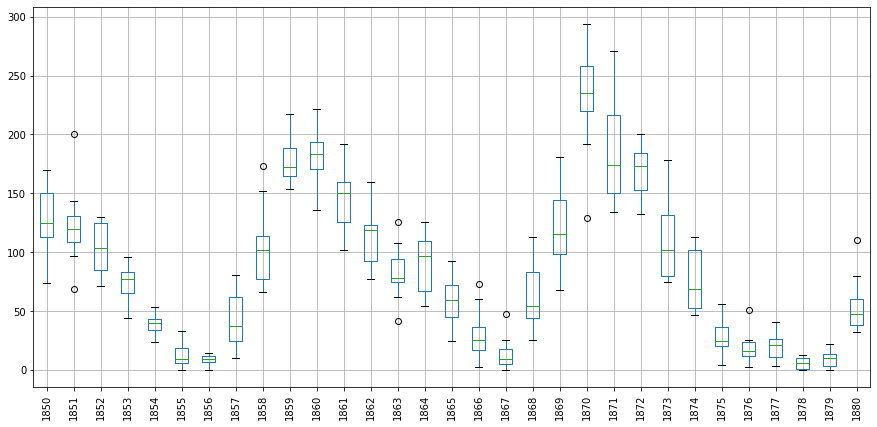

In [17]:
# squeeze the original dataframe into a series
ser = pd.Series(df['Monthly Mean Total Sunspot Number'].values,index = df.index)
# to prevent possible errors, drop the last row in the series because 2021 has no data for months other than Jan
ser = ser.drop(pd.to_datetime('2021-01-31'))
# year_groups is the original data grouped by year
year_groups = ser.groupby(pd.Grouper(freq='Y'))
df_years = pd.DataFrame()

for year, group in year_groups:
    df_years[year.year] = group.values
# df_years is a dataframe with a column for each year in the data, and a row for every month within that year
# boxplots for sunspot data between the years 1950 and 2000
df_years.loc[:,1850:1880].boxplot(figsize = (15,7), rot = 90)

From the boxplots above, we can see that the IQR over the years tends to elongate during periods of high solar activity, but squeeze during low activity periods.

We can quantitatively confirm this by plotting the interquartile range for each year and noticing that it has peaks around periods of high solar activity, and troughs around low ones:

<AxesSubplot:xlabel='Year'>

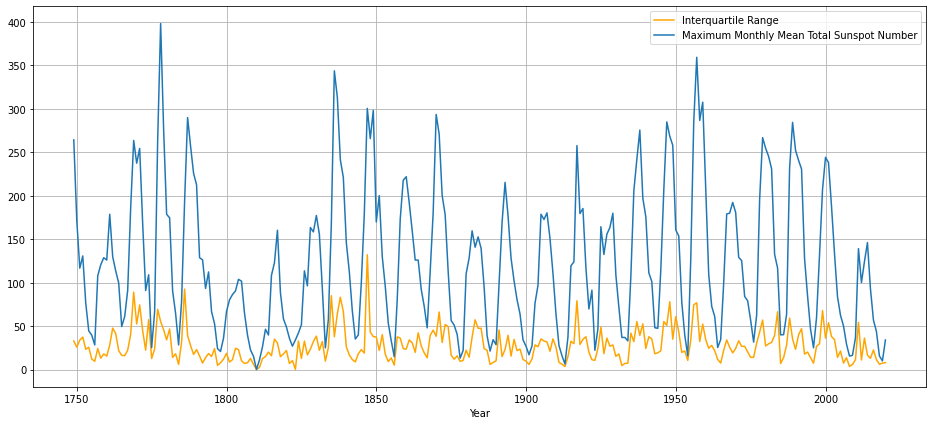

In [18]:
interquartile_range_years = df_years.quantile(0.75) - df_years.quantile(0.25)
interquartile_range_years.name = 'Interquartile Range'
ax = interquartile_range_years.plot(color = 'orange', legend = True)
df_years_max = df_years.max()
df_years_max.name = 'Maximum Monthly Mean Total Sunspot Number'
df_years_max.plot(ax = ax, figsize = (16,7), grid = True, xlabel = 'Year', legend = True)

We can check the correlation between IQR and the maximum value of 'Monthly Mean Total Sunspot Number' (both defined per year):

In [19]:
IQR_SSN_corr = pd.DataFrame([df_years.max(),interquartile_range_years]).transpose()
IQR_SSN_corr.corr()

,Unnamed 0,Interquartile Range
Unnamed 0,1.000000,0.718423
Interquartile Range,0.718423,1.000000


So we get a positive correlation of about 0.72. Although this is not very strong, it does roughly show that (per year) when solar activity increases, the observed sunspot numbers vary greatly. 

We can also verify that the IQR displays seasonality just like the local minima and maxima in the original sunspot data line plot. For that, we make an autocorrelation plot of IQR (with lag time in years):

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

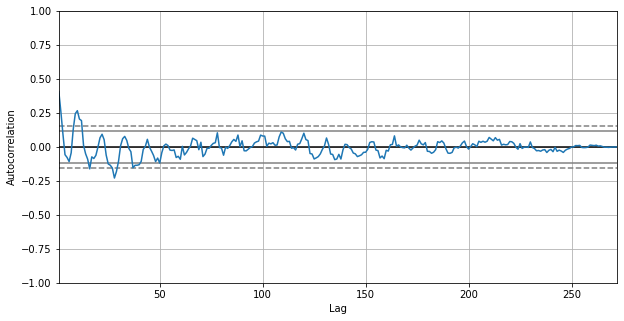

In [20]:
plt.figure(figsize = (10,5))
pd.plotting.autocorrelation_plot(interquartile_range_years)

Here, although the autocorrelation at the first peak is not too strong, it does signal the presence of seasonality. We can find the lag time at this peak and the autocorrelation value at this lag time as follows:

In [21]:
lag_val = np.arange(15)
autocorr_ser = np.array([interquartile_range_years.autocorr(lag=n) for n in lag_val])
argrelextrema(autocorr_ser, np.greater, order = 1)[0]

array([10])

So the first peak of the autocorrelation plot above occurs at lag = **10 years**. The value of this autocorrelation is: 

In [22]:
interquartile_range_years.autocorr(lag=10)

0.2720341931019332

Again, we see that the autocorrelation plot for the interquartile range over the years displays seasonality - there is a local maximum at a lag = 10 years, which corresponds (roughly) to the **solar cycle** calculated from the original month-wise sunspot data which gave us 10.67. The IQR basically measures how quickly sunspot numbers change over time - a larger IQR means that the change is quicker. What we have found is that the IQR itself has seasonality. Although the autocorrelation of IQR is 0.27 and not very high, it is still beyond the 95% and 99% confidence bands. It matches the seasonality in the original month-wise sunspot number data. We can conclude that whenever sunspot numbers rise, they will tend to rise at a faster rate than when they change during low solar activity. This means two things - 1) the rate of change of sunspot numbers depends on whether the time period in question corresponds to low or high solar activity and 2) this phenomenon is not a fluke but actually displays repetitive pattern, exactly in line with the solar cycle itself.

A heatmap provides an interesting visualization of the sunspot number. Brighter colors correspond to higher values of the 'Monthly Mean Total Sunspot Number' and darker ones to lower.

Text(0.5, 1.0, 'Heatmap of Monthly Mean Total Sunspot Number over the years')

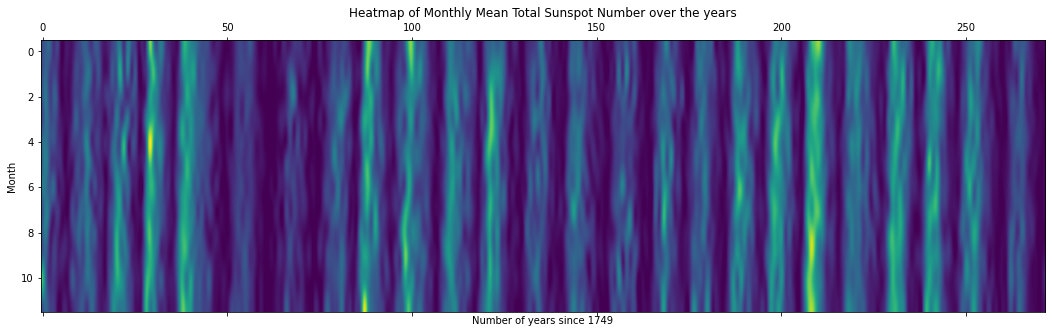

In [23]:
fig, ax = plt.subplots(figsize=(18, 5))
ax.matshow(df_years, interpolation='lanczos', aspect='auto')
ax.set_xlabel('Number of years since 1749')
ax.set_ylabel('Month')
ax.set_title('Heatmap of Monthly Mean Total Sunspot Number over the years')

The heatmap reveals two seasons: 1) the solar cycle of around 11 years and 2) a longer cycle of about 100 years - the brightness of the bright bands oscillate in a specific pattern. Moving forward in time, if the bright bands get brighter, they tend to keep getting brighter further. Looking at the repetitive pattern of the bright bands' brightness, one can see that it possesses seasonality with a time period of about **100 years**. This is exactly what we found from the autocorrelation plot of the full sunspot data earlier.

We can also visualize the local maxima in sunspot numbers over the years:

<AxesSubplot:title={'center':'Local maxima in monthly mean sunspot numbers'}, xlabel='Month (in a year)', ylabel='Monthly Mean Total Sunspot Number'>

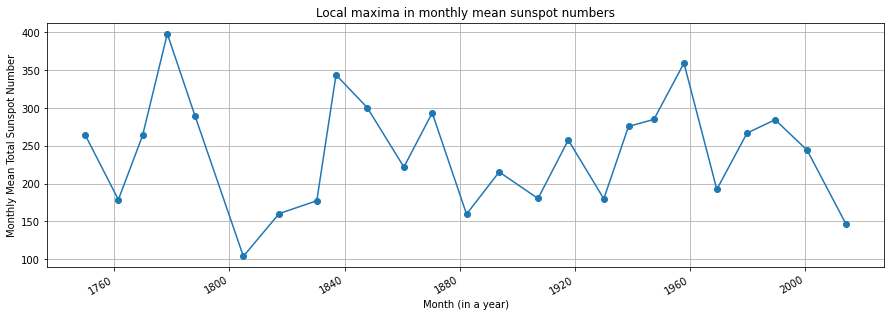

In [24]:
# we set an order that corresponds to a 4 year time frame - the time period to be used for comparison
# to the left and right of a putative local maximum data point
order = 12*4
argrelextrema(ser.values, np.greater, order = order)[0]
local_maxima = ser[argrelextrema(ser.values,np.greater, order = order)[0]]
local_maxima.sort_values(ascending = False)
ax = local_maxima.plot(grid = True, figsize = (15,5), style = 'o-', ylabel = 'Monthly Mean Total Sunspot Number', xlabel = 'Month (in a year)', title = 'Local maxima in monthly mean sunspot numbers')
ax

How many data points are there in local_maxima? We can easily check this:

In [25]:
local_maxima.count()

25

25 is *exactly* the number we expect - a quick but careful glance at the first line plot of all the 3265 entries in the data, we obtain 25 local maxima in sunspot numbers over the years.

We can define '**sunspot cycles**' to be the difference between consecutive maxima. They are easily computed as follows:

In [26]:
sunspot_cycles = local_maxima.reset_index()['Date'].dt.year.diff().dropna()
sunspot_cycles

1     12.0
2      8.0
3      9.0
4      9.0
5     17.0
6     13.0
7     13.0
8      6.0
9     11.0
10    13.0
11    10.0
12    12.0
13    11.0
14    14.0
15    10.0
16    12.0
17     9.0
18     9.0
19    10.0
20    12.0
21    10.0
22    10.0
23    11.0
24    14.0
Name: Date, dtype: float64

In [27]:
sunspot_cycles.describe()

count    24.000000
mean     11.041667
std       2.330873
min       6.000000
25%       9.750000
50%      11.000000
75%      12.250000
max      17.000000
Name: Date, dtype: float64

So we see that the mean time period of sunspot cycles turns out to be **11.04 years**, which agrees with the well-known **solar cycle**.

It is tempting to wonder if the time period of 11 years is perhaps the mean of a **normal distribution**. To see that, we plot a histogram:

<AxesSubplot:>

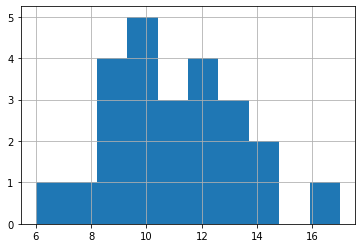

In [28]:
sunspot_cycles.hist()

This hints that the distribution of solar cycles is close to a normal distribution (although not clearly). To quantify and visualize its similarity to a normal curve, we draw a **Quantile-Quantile (QQ) plot**:

/opt/conda/lib/python3.7/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


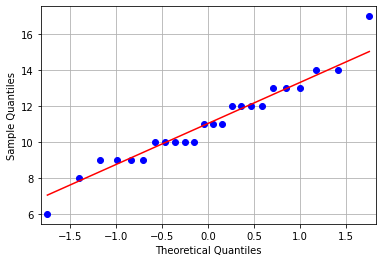

In [29]:
qqplot_sunspot_cycles = sm.qqplot(sunspot_cycles, line = 's')
plt.grid()

So although the data points do not strictly adhere to a standard normal curve line, the QQ plot still does show that solar cycles seem to be normally distributed. Perhaps more data about observed sunspot numbers will result in a tighter fit to a normal distribution. This direct approach may not be so feasible, however, since it takes centuries to collect a reasonable number of data points corresponding to solar cycle maxima.

It is harder to find local minima than maxima because there are a couple of consecutive minimum data points, resulting in flat (and not sharp) minimas. This is expected because, as we saw earlier, during periods of minima, sunspot numbers tend to not vary much (when compared to periods of high solar activity). We can have a brief look at the local minima. We consider an order of 10 years for comparison when finding local minima, and obtain:

In [30]:
order = 12*10
argrelextrema(ser.values, np.less, order = order)[0]
local_minima = ser[argrelextrema(ser.values,np.less_equal, order = order)[0]]
print(local_minima.count())
local_minima

77


Date
1754-01-31    0.0
1755-05-31    0.0
1755-06-30    0.0
1775-02-28    0.0
1798-05-31    0.0
             ... 
1986-06-30    0.6
1996-10-31    0.7
2009-08-31    0.0
2020-02-29    0.2
2020-05-31    0.2
Length: 77, dtype: float64

There are 77 minima in this data. Clearly, there are more minima than expected. From looking at the first line plot of the full data, we can quickly count the number of minima to be 25. The nearly 50 extra minima appear because they are quite close to other minima. This happens especially during the **Dalton Minimum** as we will see soon. The Monthly Mean Total Sunspot Number values at these minima are:

In [31]:
local_minima.value_counts()

0.0    67
0.4     5
0.2     2
0.7     1
0.3     1
0.6     1
dtype: int64

which shows that there are many nearby minima with a value of 0.0. These flat minima are prevalent during the **Dalton Minimum** period, so we plot it below for visual confirmation:

<AxesSubplot:xlabel='Month (in a year)', ylabel='Monthly Mean Total Sunspot Number'>

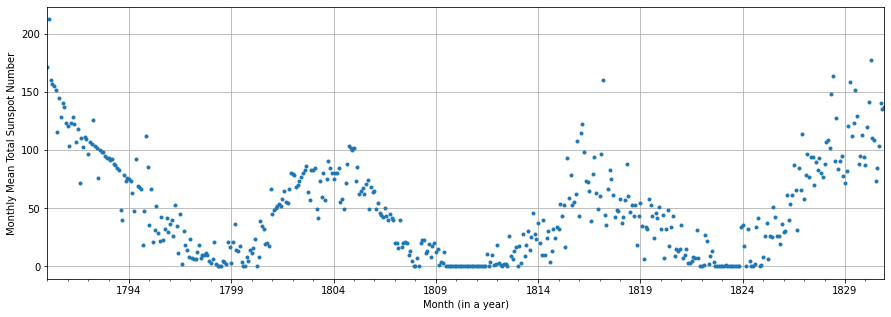

In [32]:
df.loc['1790':'1830'].plot(figsize = (15,5),grid = True, xlabel = 'Month (in a year)', ylabel = 'Monthly Mean Total Sunspot Number', legend = False, style = '.')

We see an especially low sunspot number count throughout the years. Moreover, we see that there are consecutive zeros for many months during the two minima around 1810 and 1823.

# Conclusions and outlook

We have seen that the sunspot numbers data provides us with very interesting patterns in a time series: seasonality (of both 11 years and 120 years), sharp maxima, flatter minima, asymmetry between rises and falls, and low sunspot number variation during periods of minima (and vice versa).

Next, it would be interesting to devise a machine learning algorithm to predict sunspot numbers as accurately as possible. This may be challenging, however, due to lack of enough data.

# References

1. "The Solar Cycle", David H. Hathaway, https://arxiv.org/abs/1502.07020v1
2. https://en.wikipedia.org/wiki/Dalton_Minimum
3. https://en.wikipedia.org/wiki/Year_Without_a_Summer
4. https://peratonweather.com/blog/2020/1/16/715-am-the-solar-minimum-and-an-increase-in-volcanic-activity
2. https://machinelearningmastery.com/time-series-data-visualization-with-python/
3. https://www.statisticshowto.com/lag-plot/
4. https://www.datadoghq.com/blog/timeseries-metric-graphs-101/
5. https://www.itl.nist.gov/div898/handbook/eda/section3/autocopl.htm
6. https://www.itl.nist.gov/div898/handbook/eda/eda.htm
7. https://ourcodingclub.github.io/tutorials/pandas-time-series/
8. https://www.machinelearningplus.com/time-series/time-series-analysis-python/